In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

# Downloading or Loading the data

In [4]:
train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [5]:
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Creating Loaders

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Defining strings for labels

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [3 7 9 4 3 8 0 6 9 9]
Class:    cat horse truck  deer   cat  ship plane  frog truck truck


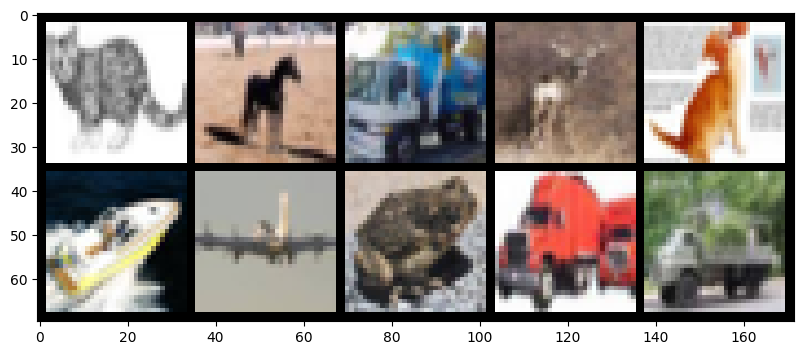

In [10]:
for images,labels in train_loader: 
    break

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

String for labels means: we can see from the above grid of images 'label 6 for frog, 5 for dog, and 9 for truck and so along'.

In [11]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

# Defining class for our Model

In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [14]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for param in model.parameters():
    print(param.numel())

162
6
864
16
69120
120
10080
84
840
10


Total parameters = 81302

# Defining Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the Model

In [18]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.97580528  accuracy:  24.300%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.80841255  accuracy:  29.590%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.68800998  accuracy:  32.840%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.78803635  accuracy:  35.180%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.83383274  accuracy:  37.166%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.10154605  accuracy:  46.330%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.62345278  accuracy:  47.525%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.79349041  accuracy:  48.110%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.18415272  accuracy:  48.640%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.00579572  accuracy:  49.404%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.69991553  accuracy:  53.900%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.40387249  accuracy:  53.795%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.42830873  accuracy:  54.270%
epoch:  2  b

In [19]:
torch.save(model.state_dict(),'CIFER10-CNN-MODEL.pt')

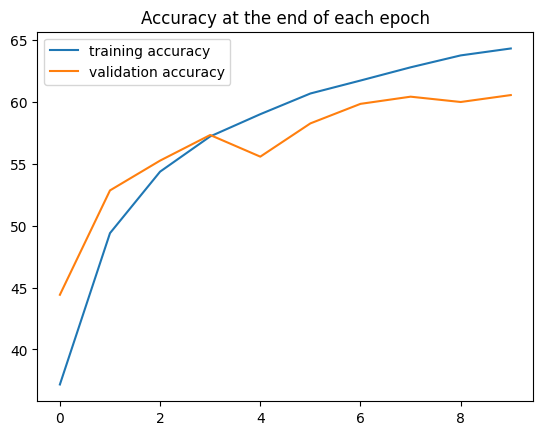

In [24]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();